In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import pandas as pd
import pickle
import os
import shap
import random
import numpy as np
import dice_ml
from dice_ml import Dice

## Random Forest - Cross Validation and Hyperparameter selection

In [2]:
# Import data
data = pd.read_pickle("weather_prediction_dataset_cleaned.pkl")

In [3]:
# Set print diplay options so the output is not truncated
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.expand_frame_repr', False)  # Prevent line breaks for long rows
pd.set_option('display.max_colwidth', None)  # Do not truncate columns with long text
pd.set_option('display.width', 2000)  # Sets the width of the display

In [35]:
# Get list of cities based on the target columns
cities = [col.rsplit('_', 1)[0] for col in data.columns if col.endswith('_sunshine')]

# Initialize an empty list to store the results for each city
summary_data = []

# Initialize a dictionary to store models for each city
models = {}

# Loop through each city to apply Random Forest regression with hyperparameter tuning
for city in cities:
    # Select feature columns and target column for the city
    feature_columns = [col for col in data.columns if col.startswith(city) and not col.endswith('_sunshine')]
    target_column = f'{city}_sunshine'
    
    X = data[feature_columns]
    y = data[target_column]
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Set up the parameter grid for hyperparameter tuning
    param_grid = {
        'n_estimators': [50, 100, 200],  # Number of trees in the forest
        'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
        'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
        'min_samples_leaf': [1, 2, 4]     # Minimum number of samples required to be at a leaf node
    }
    
    # Initialize the Random Forest model
    rf_model = RandomForestRegressor(random_state=42)

    # Perform GridSearchCV for hyperparameter tuning
    grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, 
                               scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    # Get the best model and best hyperparameters from GridSearchCV
    best_rf_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    # Cross-validation to evaluate the model
    cv_scores = cross_val_score(best_rf_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    cv_mse = -cv_scores.mean()  # Convert to positive MSE
    
    # Fit the best model on the training data and predict on the test set
    best_rf_model.fit(X_train, y_train)
    y_pred = best_rf_model.predict(X_test)

    # Calculate evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Store the results for the current city
    summary_data.append({
        "City": city,
        "CV MSE": cv_mse,
        "Test MSE": mse,
        "Test R²": r2,
        "Best Hyperparameters": best_params
    })

    # Store the best model in the models dictionary
    models[city] = best_rf_model

    # Save the model as a pickle file
    with open(f"rf_models/{city}_rf_model.pkl", "wb") as model_file:
        pickle.dump(best_rf_model, model_file)

# Convert the list of dictionaries into a DataFrame for easy viewing
summary_df = pd.DataFrame(summary_data)

# Display the summary table
print(summary_df.round(3))

# Now, you can access the models by city, for example:
# models['CityName'] to retrieve the Random Forest model for that city

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Fitting 5 folds for each of 108 candidates, totalling 540 fits
          City  CV MSE  Test MSE  Test R²                                                                      Best Hy

### <font color='orange'> Random forest achieves better Mean Squared Error and R-squared results for every city.

### <font color='green'> 1) it is better across all cities in cross-validation mean squared error (= better performance on unseen data when doing multiple folds)
### <font color='green'> 2) it is better across all cities in mean squared error (= better performance for a specific, separate test set)
### <font color='green'> 3) it is better across all cities in R2 (= better fits the data, better explains the variance in sunshine)
### <font color='green'> 4) it works well under multicollinearity compared to Linear regression, because it randomly selects a subset of features for each tree node, making it unlikely that two correlated features will be selected for the same model.
### <font color="green"> 5) Multicollinearity would not impact the prediction performance of the model. Its traces might be visible in feature importances, which is why we will use SHAP values for more accurate feature interpretation.

## <font color='red'> Feature Importance

### <font color='blue'> Use SHAP with Random Forest

#### <font color="green"> For every city we have provided Gini and SHAP feature importance analysis.


Feature Importance for BASEL:
                  Feature  Importance
3  BASEL_global_radiation    0.599119
0       BASEL_cloud_cover    0.352802
2          BASEL_pressure    0.012149
6          BASEL_temp_min    0.010603
1          BASEL_humidity    0.008230
7          BASEL_temp_max    0.008015
4     BASEL_precipitation    0.004940
5         BASEL_temp_mean    0.004142
SHAP Summary Plot for BASEL:


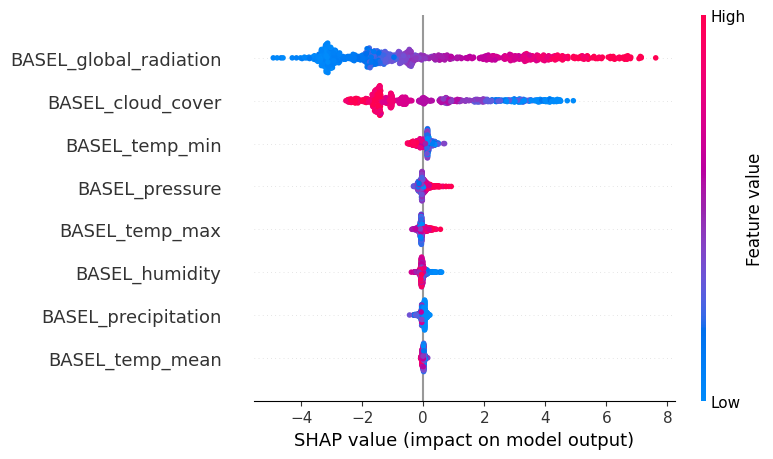

SHAP Dependence Plot for BASEL (first feature):


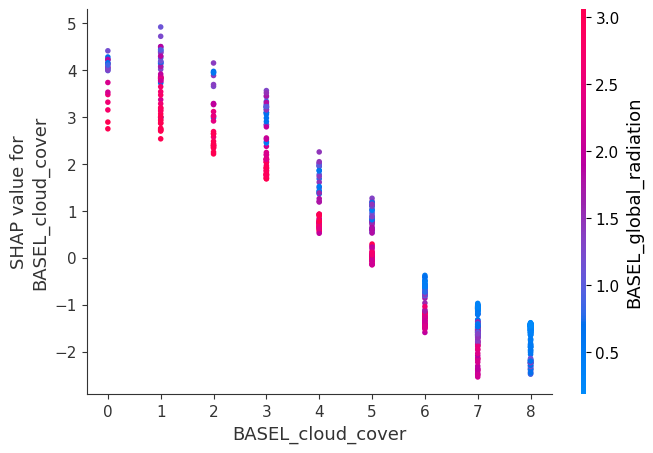





****************************************************************************************************

Feature Importance for BUDAPEST:
                     Feature  Importance
3  BUDAPEST_global_radiation    0.694268
0       BUDAPEST_cloud_cover    0.272427
1          BUDAPEST_humidity    0.011324
2          BUDAPEST_pressure    0.008565
6          BUDAPEST_temp_max    0.005575
5         BUDAPEST_temp_mean    0.005454
4     BUDAPEST_precipitation    0.002388
SHAP Summary Plot for BUDAPEST:


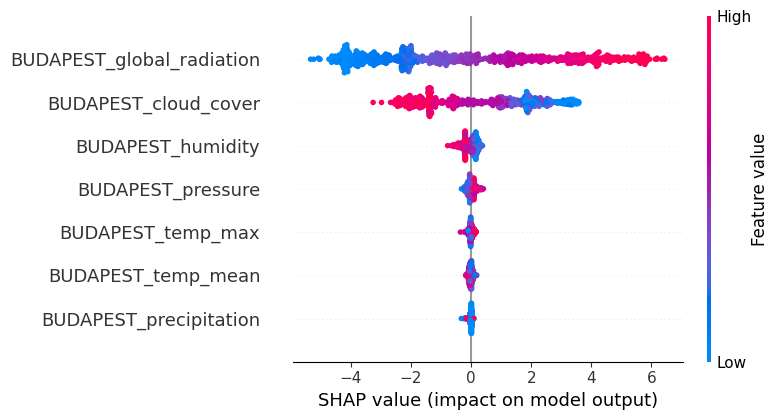

SHAP Dependence Plot for BUDAPEST (first feature):


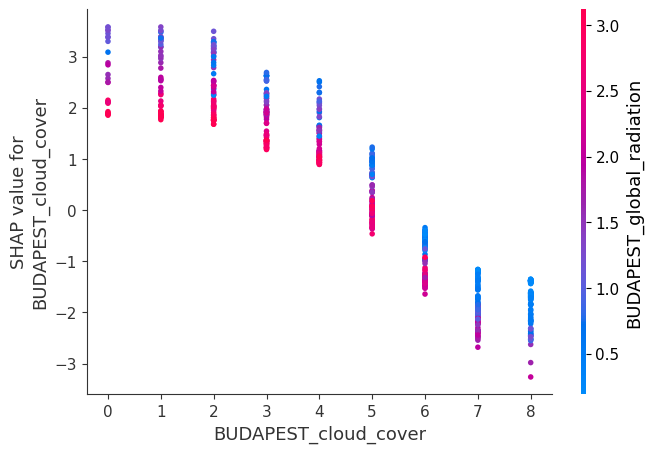





****************************************************************************************************

Feature Importance for DEBILT:
                   Feature  Importance
5  DEBILT_global_radiation    0.697524
0       DEBILT_cloud_cover    0.257429
7         DEBILT_temp_mean    0.010039
8          DEBILT_temp_min    0.007052
9          DEBILT_temp_max    0.006327
3          DEBILT_humidity    0.006000
4          DEBILT_pressure    0.005453
1        DEBILT_wind_speed    0.005063
6     DEBILT_precipitation    0.002857
2         DEBILT_wind_gust    0.002256
SHAP Summary Plot for DEBILT:


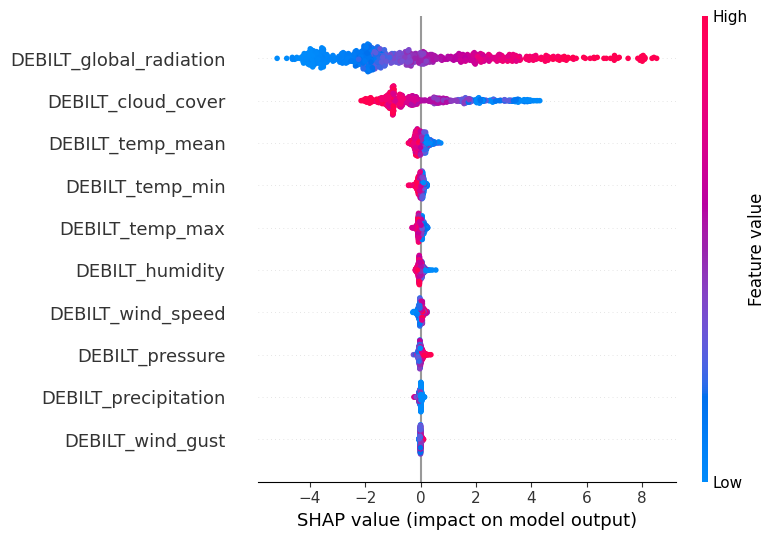

SHAP Dependence Plot for DEBILT (first feature):


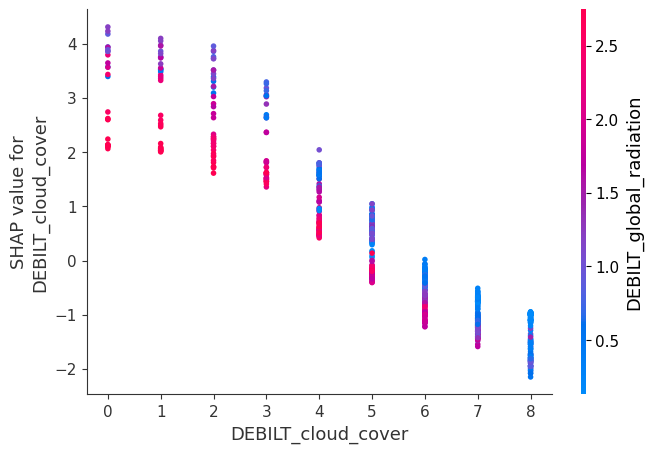





****************************************************************************************************

Feature Importance for DRESDEN:
                    Feature  Importance
4  DRESDEN_global_radiation    0.688962
0       DRESDEN_cloud_cover    0.263337
3          DRESDEN_humidity    0.012043
7          DRESDEN_temp_min    0.007292
1        DRESDEN_wind_speed    0.006807
2         DRESDEN_wind_gust    0.006680
8          DRESDEN_temp_max    0.006230
6         DRESDEN_temp_mean    0.005090
5     DRESDEN_precipitation    0.003559
SHAP Summary Plot for DRESDEN:


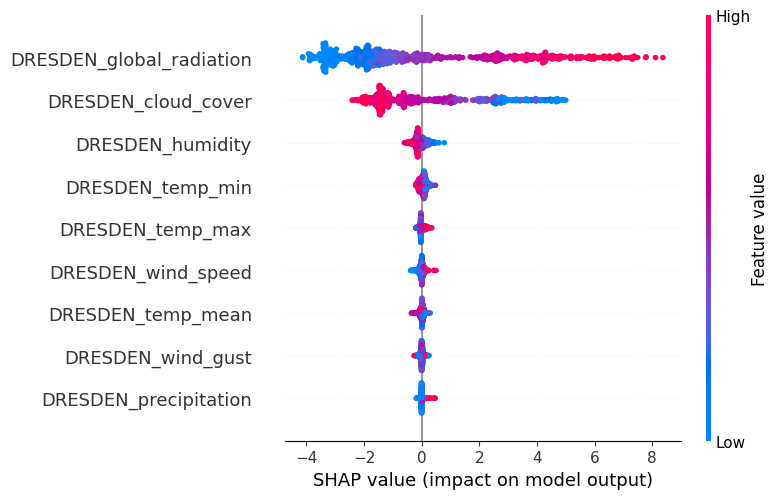

SHAP Dependence Plot for DRESDEN (first feature):


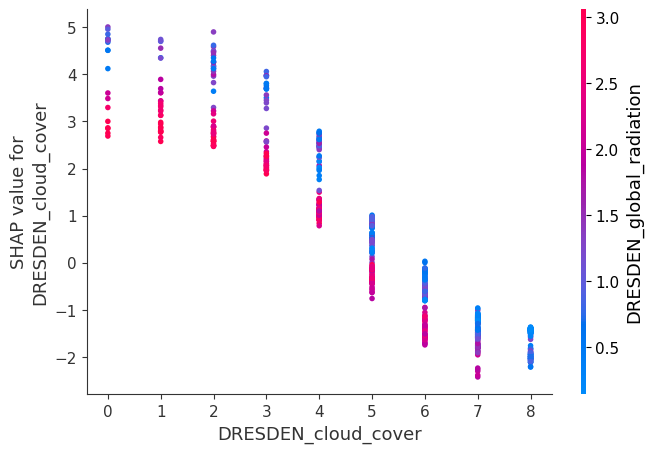





****************************************************************************************************

Feature Importance for DUSSELDORF:
                       Feature  Importance
5  DUSSELDORF_global_radiation    0.576733
0       DUSSELDORF_cloud_cover    0.382515
3          DUSSELDORF_humidity    0.008986
4          DUSSELDORF_pressure    0.006451
8          DUSSELDORF_temp_min    0.005565
1        DUSSELDORF_wind_speed    0.004662
9          DUSSELDORF_temp_max    0.004455
2         DUSSELDORF_wind_gust    0.004325
7         DUSSELDORF_temp_mean    0.004203
6     DUSSELDORF_precipitation    0.002106
SHAP Summary Plot for DUSSELDORF:


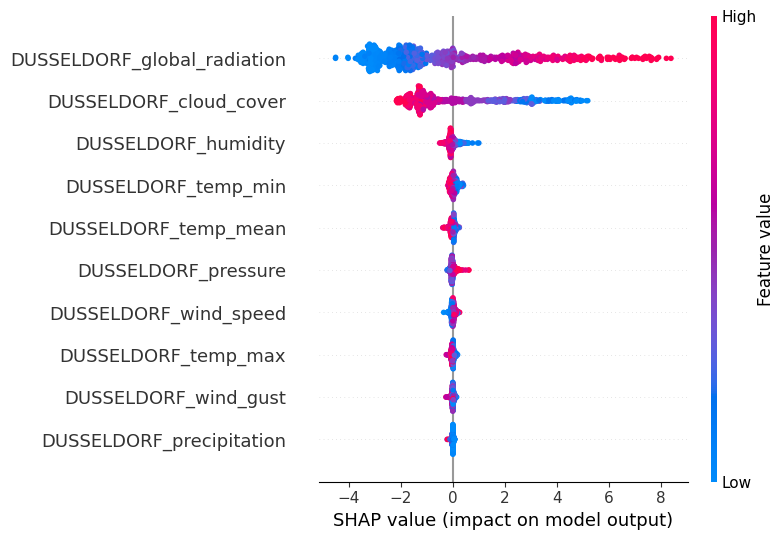

SHAP Dependence Plot for DUSSELDORF (first feature):


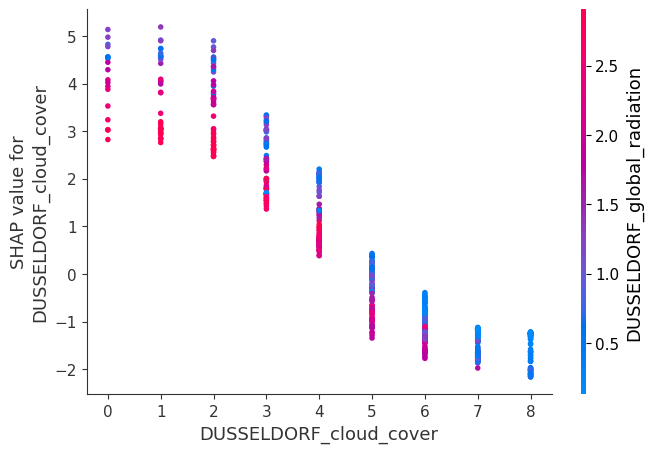





****************************************************************************************************

Feature Importance for HEATHROW:
                     Feature  Importance
3  HEATHROW_global_radiation    0.752467
0       HEATHROW_cloud_cover    0.188261
7          HEATHROW_temp_max    0.015133
2          HEATHROW_pressure    0.014569
1          HEATHROW_humidity    0.009793
6          HEATHROW_temp_min    0.008678
5         HEATHROW_temp_mean    0.007322
4     HEATHROW_precipitation    0.003776
SHAP Summary Plot for HEATHROW:


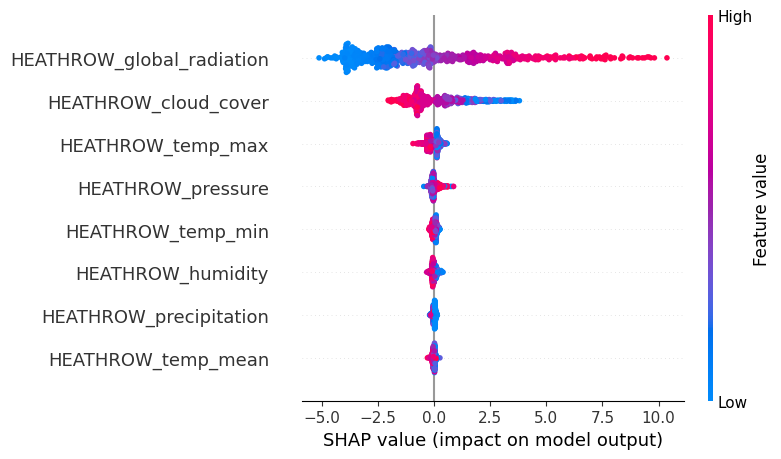

SHAP Dependence Plot for HEATHROW (first feature):


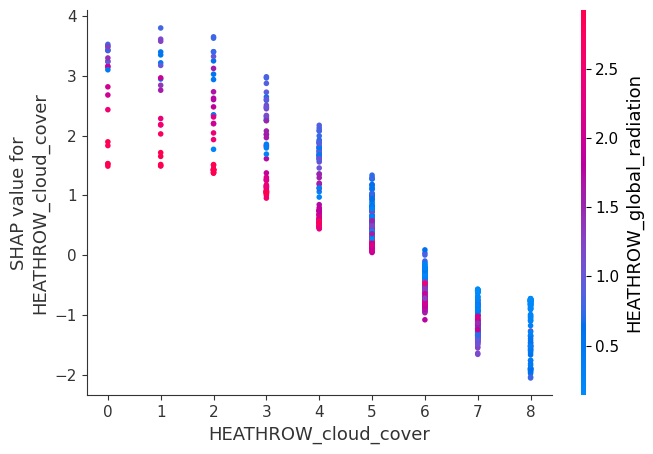





****************************************************************************************************

Feature Importance for KASSEL:
                   Feature  Importance
4  KASSEL_global_radiation    0.804239
2          KASSEL_humidity    0.039344
3          KASSEL_pressure    0.035741
7          KASSEL_temp_min    0.035015
5     KASSEL_precipitation    0.033012
8          KASSEL_temp_max    0.016807
1         KASSEL_wind_gust    0.015452
0        KASSEL_wind_speed    0.010896
6         KASSEL_temp_mean    0.009494
SHAP Summary Plot for KASSEL:


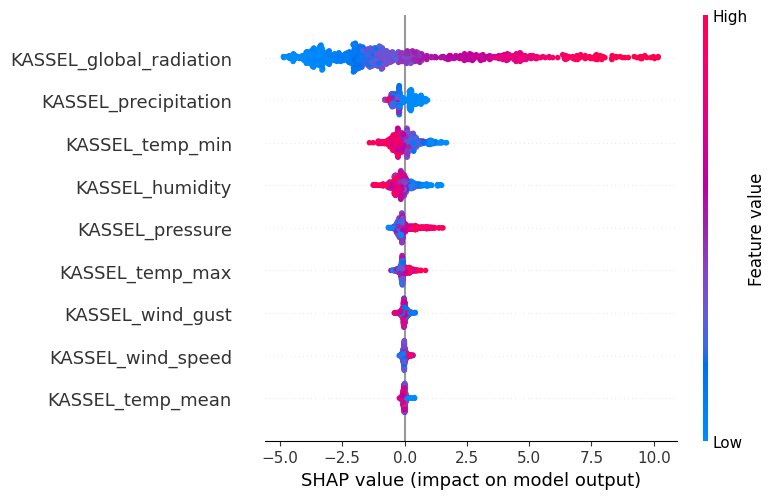

SHAP Dependence Plot for KASSEL (first feature):


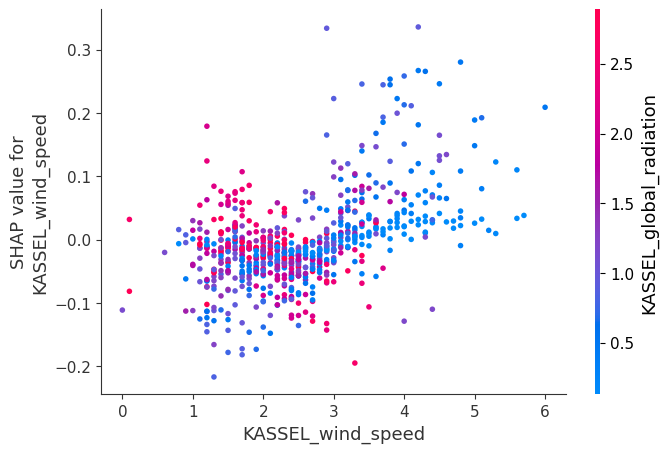





****************************************************************************************************

Feature Importance for LJUBLJANA:
                      Feature  Importance
4  LJUBLJANA_global_radiation    0.772641
0       LJUBLJANA_cloud_cover    0.199525
7          LJUBLJANA_temp_min    0.006617
2          LJUBLJANA_humidity    0.005696
3          LJUBLJANA_pressure    0.004800
8          LJUBLJANA_temp_max    0.003458
1        LJUBLJANA_wind_speed    0.002955
6         LJUBLJANA_temp_mean    0.002528
5     LJUBLJANA_precipitation    0.001780
SHAP Summary Plot for LJUBLJANA:


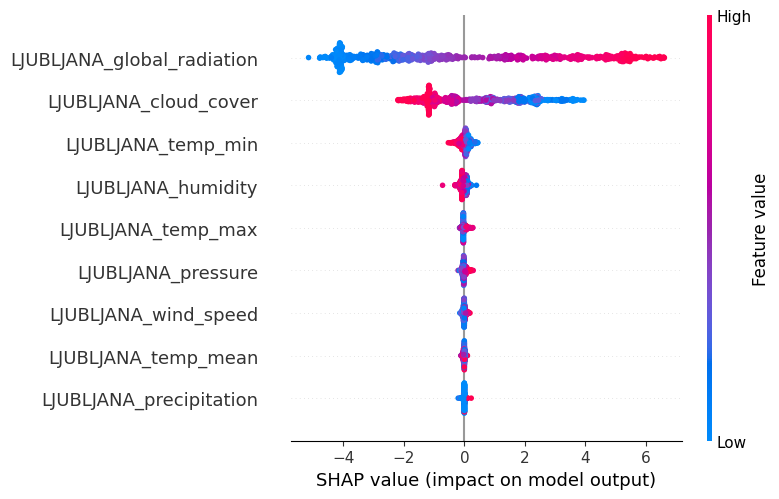

SHAP Dependence Plot for LJUBLJANA (first feature):


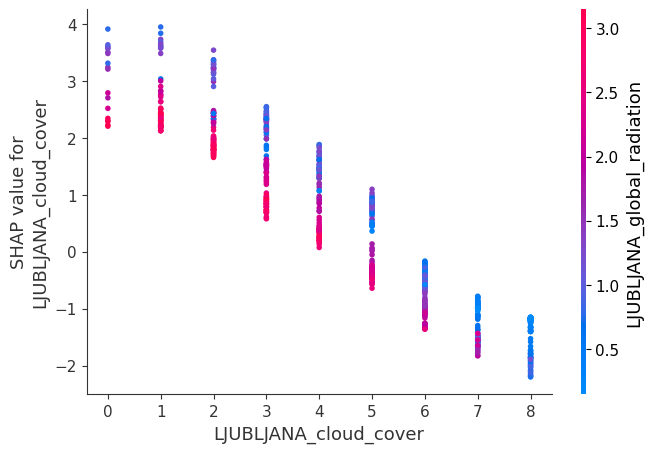





****************************************************************************************************

Feature Importance for MAASTRICHT:
                       Feature  Importance
0       MAASTRICHT_cloud_cover    0.642676
5  MAASTRICHT_global_radiation    0.306423
3          MAASTRICHT_humidity    0.010954
8          MAASTRICHT_temp_min    0.008209
7         MAASTRICHT_temp_mean    0.007803
1        MAASTRICHT_wind_speed    0.006480
4          MAASTRICHT_pressure    0.006444
9          MAASTRICHT_temp_max    0.005185
2         MAASTRICHT_wind_gust    0.003283
6     MAASTRICHT_precipitation    0.002544
SHAP Summary Plot for MAASTRICHT:


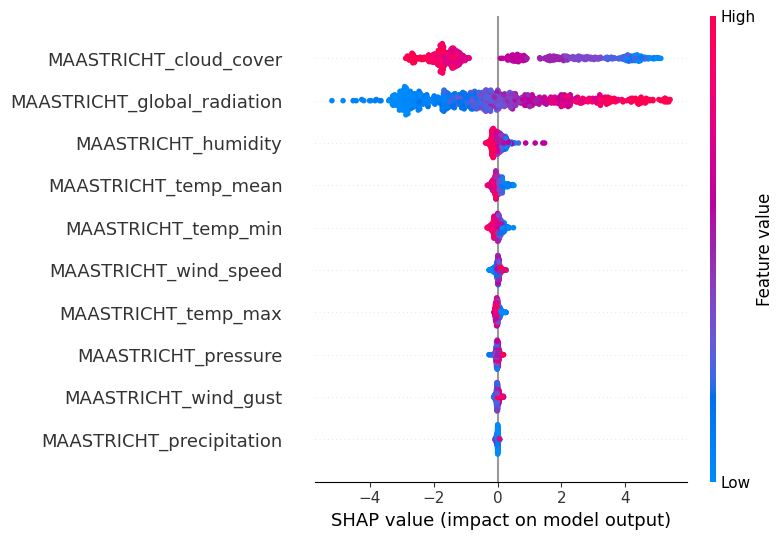

SHAP Dependence Plot for MAASTRICHT (first feature):


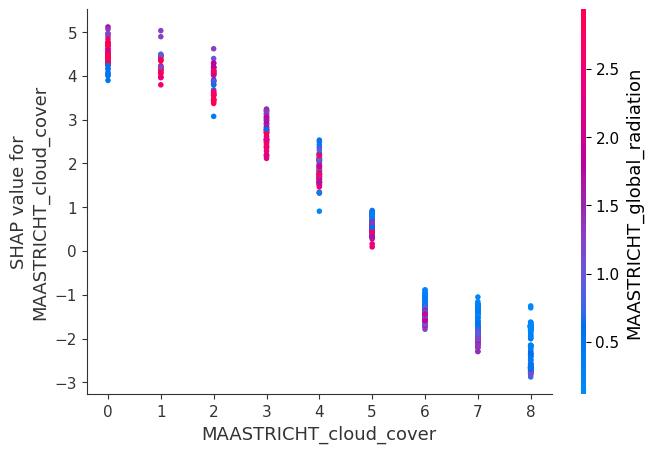





****************************************************************************************************

Feature Importance for MUENCHEN:
                     Feature  Importance
5  MUENCHEN_global_radiation    0.584800
0       MUENCHEN_cloud_cover    0.369613
8          MUENCHEN_temp_min    0.009137
3          MUENCHEN_humidity    0.007558
2         MUENCHEN_wind_gust    0.006544
4          MUENCHEN_pressure    0.006329
1        MUENCHEN_wind_speed    0.005204
9          MUENCHEN_temp_max    0.004759
6     MUENCHEN_precipitation    0.003081
7         MUENCHEN_temp_mean    0.002973
SHAP Summary Plot for MUENCHEN:


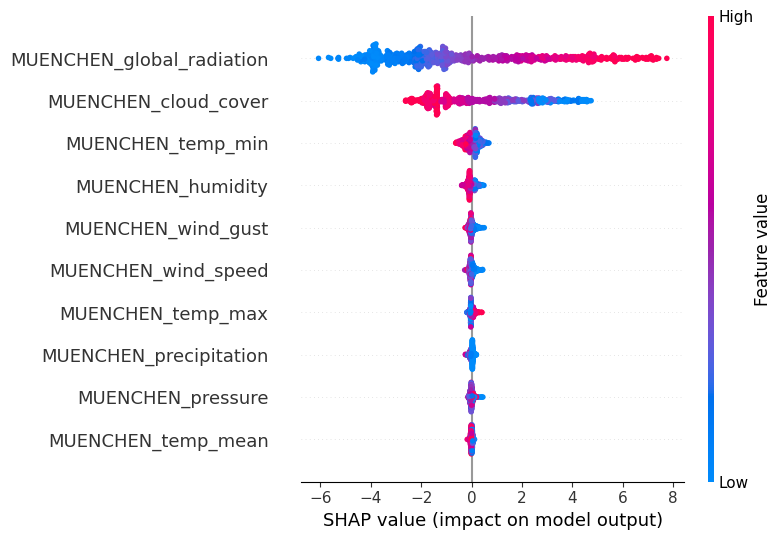

SHAP Dependence Plot for MUENCHEN (first feature):


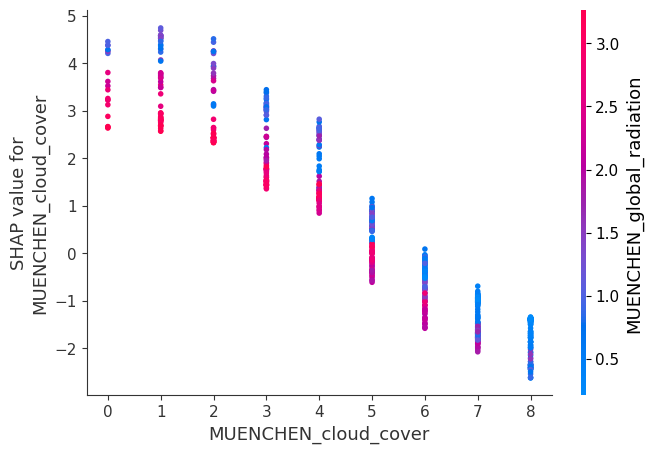





****************************************************************************************************

Feature Importance for OSLO:
                 Feature  Importance
5  OSLO_global_radiation    0.615188
0       OSLO_cloud_cover    0.229998
3          OSLO_humidity    0.043955
4          OSLO_pressure    0.037985
2         OSLO_wind_gust    0.020125
8          OSLO_temp_min    0.012578
6     OSLO_precipitation    0.010666
1        OSLO_wind_speed    0.010665
7         OSLO_temp_mean    0.009448
9          OSLO_temp_max    0.009391
SHAP Summary Plot for OSLO:


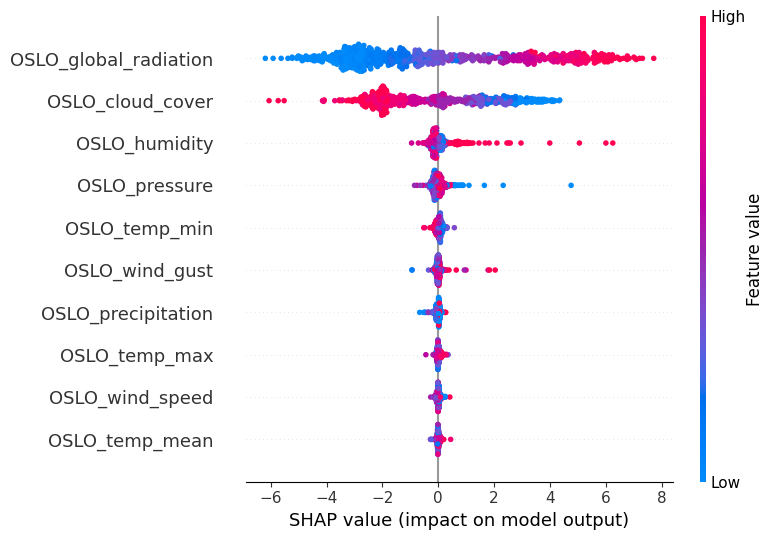

SHAP Dependence Plot for OSLO (first feature):


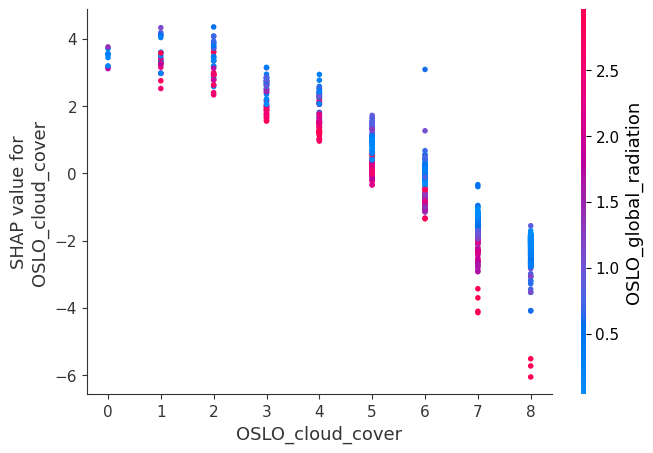





****************************************************************************************************

Feature Importance for ROMA:
                 Feature  Importance
0       ROMA_cloud_cover    0.554511
3  ROMA_global_radiation    0.407172
5          ROMA_temp_min    0.008377
2          ROMA_pressure    0.008037
1          ROMA_humidity    0.008013
6          ROMA_temp_max    0.007285
4         ROMA_temp_mean    0.006605
SHAP Summary Plot for ROMA:


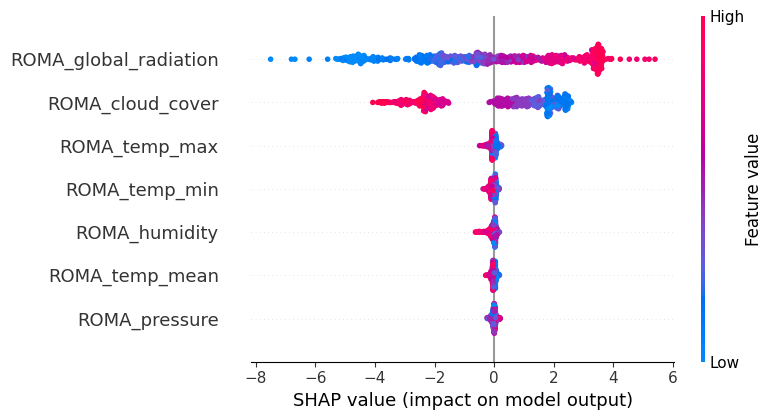

SHAP Dependence Plot for ROMA (first feature):


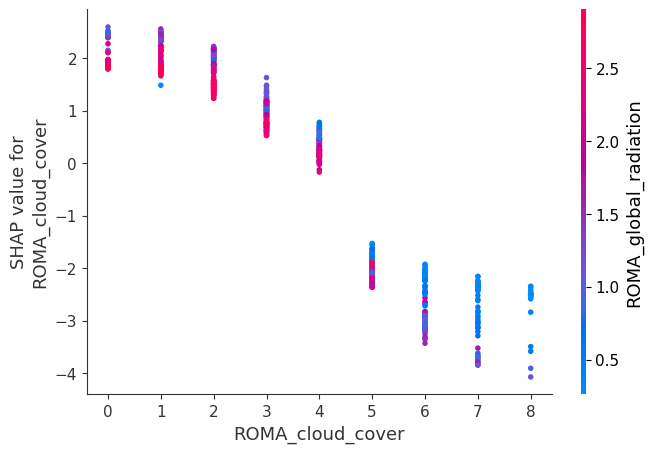





****************************************************************************************************

Feature Importance for SONNBLICK:
                      Feature  Importance
0       SONNBLICK_cloud_cover    0.731244
2  SONNBLICK_global_radiation    0.194189
1          SONNBLICK_humidity    0.032458
6          SONNBLICK_temp_max    0.012512
3     SONNBLICK_precipitation    0.011929
5          SONNBLICK_temp_min    0.009557
4         SONNBLICK_temp_mean    0.008112
SHAP Summary Plot for SONNBLICK:


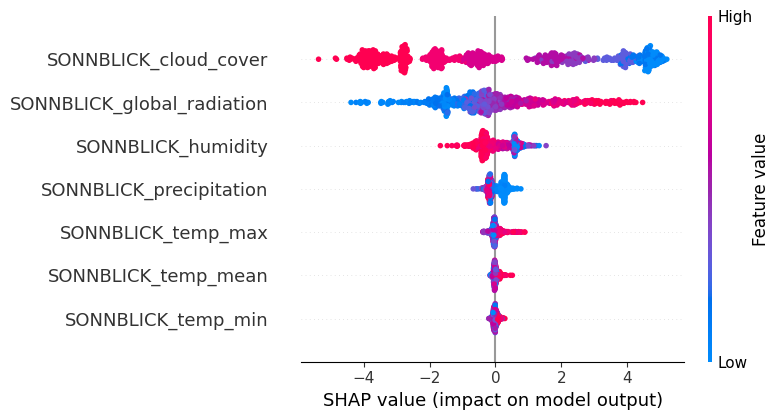

SHAP Dependence Plot for SONNBLICK (first feature):


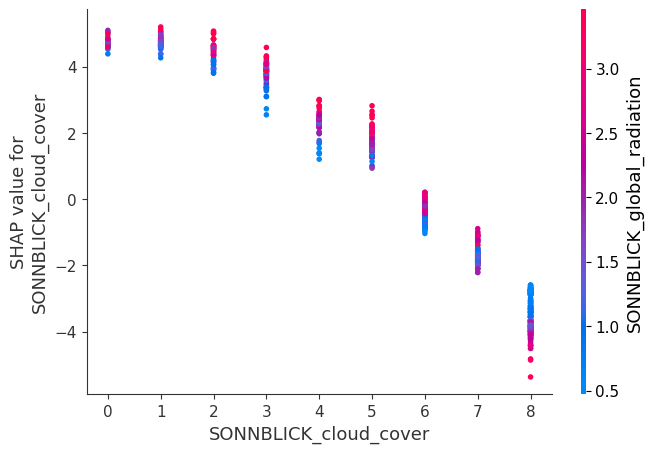





****************************************************************************************************

Feature Importance for STOCKHOLM:
                   Feature  Importance
0    STOCKHOLM_cloud_cover    0.643453
5       STOCKHOLM_temp_max    0.240459
4       STOCKHOLM_temp_min    0.052371
1       STOCKHOLM_pressure    0.031375
3      STOCKHOLM_temp_mean    0.022913
2  STOCKHOLM_precipitation    0.009428
SHAP Summary Plot for STOCKHOLM:


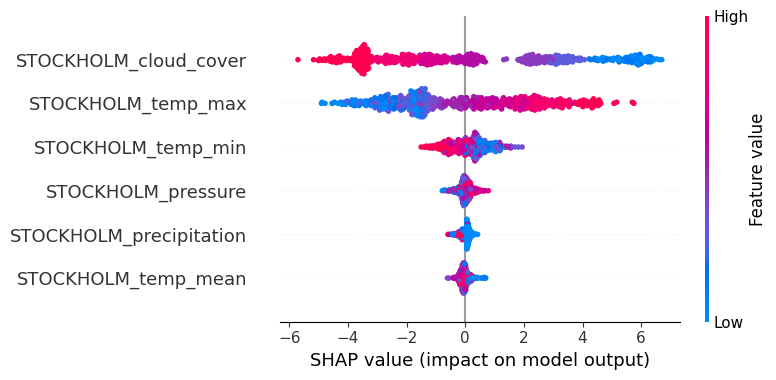

SHAP Dependence Plot for STOCKHOLM (first feature):


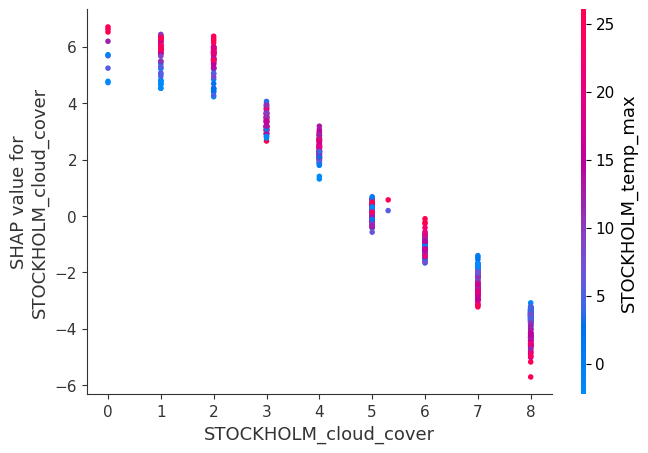





****************************************************************************************************
          City  Test MSE  Test R²
0        BASEL     1.473    0.924
1     BUDAPEST     1.405    0.930
2       DEBILT     1.046    0.933
3      DRESDEN     1.873    0.908
4   DUSSELDORF     1.023    0.944
5     HEATHROW     1.355    0.915
6       KASSEL     1.868    0.895
7    LJUBLJANA     1.199    0.941
8   MAASTRICHT     1.212    0.929
9     MUENCHEN     0.901    0.959
10        OSLO     4.623    0.799
11        ROMA     1.239    0.923
12   SONNBLICK     3.073    0.850
13   STOCKHOLM     5.469    0.773


In [39]:
# Get list of cities based on the target columns
cities = [col.rsplit('_', 1)[0] for col in data.columns if col.endswith('_sunshine')]

# Initialize an empty list to store the results for each city
summary_data = []

# Loop through each city to load the saved models and perform SHAP integration
for city in cities:
    # Load the saved model for the city
    model_path = f"rf_models/{city}_rf_model.pkl"
    
    if os.path.exists(model_path):
        # Load the model from the pickle file
        with open(model_path, "rb") as model_file:
            best_rf_model = pickle.load(model_file)
        
        # Select feature columns and target column for the city
        feature_columns = [col for col in data.columns if col.startswith(city) and not col.endswith('_sunshine')]
        target_column = f'{city}_sunshine'
        
        X = data[feature_columns]
        y = data[target_column]
        
        # Split the data into training and testing sets (same split as before)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Evaluate the model on the test set
        y_pred = best_rf_model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        # Store the results for the current city
        summary_data.append({
            "City": city,
            "Test MSE": mse,
            "Test R²": r2
        })

        # Feature Importance
        feature_importances = best_rf_model.feature_importances_
        importance_df = pd.DataFrame({
            'Feature': feature_columns,
            'Importance': feature_importances
        }).sort_values(by='Importance', ascending=False)

        print(f"\nFeature Importance for {city}:")
        print(importance_df)

        # SHAP Integration for Random Forest model
        explainer = shap.TreeExplainer(best_rf_model)
        shap_values = explainer.shap_values(X_test)

        # SHAP Summary Plot for feature importance
        print(f"SHAP Summary Plot for {city}:")
        shap.summary_plot(shap_values, X_test, feature_names=feature_columns)

        # SHAP Dependence Plot for the first feature
        print(f"SHAP Dependence Plot for {city} (first feature):")
        shap.dependence_plot(feature_columns[0], shap_values, X_test)

        print("\n\n\n")
        print("*" * 100)
    else:
        print(f"Model file for {city} not found.")

# Convert the list of dictionaries into a DataFrame for easy viewing
summary_df = pd.DataFrame(summary_data)

# Display the summary table
print(summary_df.round(3))

### <font color='orange'> All random forest models for all cities have detected the strongest influence from the global_radiation and cloud_cover on the sunshine levels.

### <font color='orange'> The precipitation and wind_speed features seem to have a consistently low importance from both the Gini values and SHAP graphs, indicating they could be redundant across all cities. 

### <font color='green'> Higher cloud cover tends to decrease the model’s output. This relationship is influenced by the amount of global radiation, with lower radiation increasing the negative effect of cloud cover.

### <font color='green'> In KASSEL, the model's predictions also depend on the interaction between global_radiation and wind_spread, where higher valus of radiation are associated with lower levels of wind and SHAP values.

### <font color='green'> Model for Stockholm has placed most importance on the cloud_cover and temp_max, which differs from the Ridge regression. In general, higher maximum temperatures and lower cloud levels increase the model's output.


## <font color='red'> Counterfactual Explanations
### <font color='orange'> 1.) Library DICE_ML (https://github.com/interpretml/DiCE/tree/main) used to generate counterfactual explanations that increase the mean sunshine levels by at least 10%.
### <font color='orange'> 2.) Manually generated counterfactual explanations that increase the sunshine levels by approximatelly 1.

In [5]:
# Limit the number of rows to display for counterfactuals
num_samples_to_display = 3  # Only display results for 3 samples

In [16]:
import warnings
# Suppress specific FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

if 'DATE' in data.columns:
    data = data.drop(columns=['DATE'])

if 'MONTH' in data.columns:
    data = data.drop(columns=['MONTH'])

cities = [col.rsplit('_', 1)[0] for col in data.columns if col.endswith('_sunshine')]
for city in cities:
    # Create an empty list to hold the feature columns for the current city
    feature_columns = []
    
    # Go over all columns in the dataset to identify feature columns
    for col in data.columns:
        if col.startswith(city) and not col.endswith('_sunshine'):
            feature_columns.append(col)

    target_column = f'{city}_sunshine'
    
    # Check if the target column exists in the dataset
    if target_column not in data.columns:
        print(f"Skipping {city} because no '_sunshine' column is present.")
        continue
    
    # Create the feature matrix (X) by selecting the feature columns from the dataset
    X = data[feature_columns]
    
    # Create the target vector (y) by selecting the target column from the dataset
    y = data[target_column]
    
    # Split the dataset into training and testing sets
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Load the pre-trained Random Forest model from a pickle file
    with open(f"rf_models/{city}_rf_model.pkl", "rb") as model_file:
        model = pickle.load(model_file)
    
    y_pred = model.predict(x_test)
    # Initialize the SHAP explainer and calculate SHAP values
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(x_test)
    
    # Calculate mean absolute SHAP values for each feature
    mean_shap_values = np.mean(np.abs(shap_values), axis=0)
    
    # Create a DataFrame for SHAP values and sort it to get the top features
    shap_importance_df = pd.DataFrame({
        'Feature': feature_columns,
        'Mean SHAP Value': mean_shap_values
    }).sort_values(by='Mean SHAP Value', ascending=False)
    
    shap_importance_df.index = shap_importance_df.index.astype(str)

    # Get the top features (for example, top 5)
    top_features = shap_importance_df['Feature'].head(2).tolist()
    
    # Print or save the top features
    print(f"Top features for {city}: {top_features} are modified in counterfactuals.")

    # Make sure that the data in the DICE-ML model has the same columns as in the query_instances
    data1 = data[feature_columns + [target_column]]

    # Create DICE-ML Data object
    d = dice_ml.Data(dataframe=data1, continuous_features=feature_columns, outcome_name=target_column)
    
    # Create DICE-ML Model object
    m = dice_ml.Model(model=model, backend="sklearn", model_type='regressor')
    
    # Create a Dice instance
    exp = Dice(d, m, method="genetic")
    
    # Generate counterfactuals for a random sample of x_test
    query_instances = x_test.sample(num_samples_to_display, random_state=42)

    # Set the desired range to be at least 10% greater than the mean sunshine levels
    mean_y_pred = np.mean(y_pred)
    desired_range = [mean_y_pred * 1.1, y_pred.max()]

    counterfactuals = exp.generate_counterfactuals(query_instances, 
                                                   total_CFs=2, 
                                                   desired_range=desired_range,
                                                   features_to_vary=top_features)
    
    # Visualize the counterfactuals
    counterfactuals.visualize_as_dataframe(show_only_changes=True)
    
    print(f"\nCounterfactuals for city: {city}")
    print(counterfactuals)
    print("*" * 100)

Top features for BASEL: ['BASEL_global_radiation', 'BASEL_cloud_cover'] are modified in counterfactuals.


100%|██████████| 3/3 [00:00<00:00,  4.04it/s]

Query instance (original outcome : 3.3980345726013184)


,BASEL_cloud_cover,BASEL_humidity,BASEL_pressure,BASEL_global_radiation,BASEL_precipitation,BASEL_temp_mean,BASEL_temp_min,BASEL_temp_max,BASEL_sunshine
0,6,0.78,1.0276,0.78,0.0,1.6,-2.4,5.2,3.398035



Diverse Counterfactual set (new outcome: [5.172332677454565, 14.54398269909915])


,BASEL_cloud_cover,BASEL_humidity,BASEL_pressure,BASEL_global_radiation,BASEL_precipitation,BASEL_temp_mean,BASEL_temp_min,BASEL_temp_max,BASEL_sunshine
0,-,0.8,-,1.62,-,-,-,-,5.876270580783564
0,3.0,0.8,-,0.74,-,-,-,-,5.957308186588598


Query instance (original outcome : 0.0769745483994484)


,BASEL_cloud_cover,BASEL_humidity,BASEL_pressure,BASEL_global_radiation,BASEL_precipitation,BASEL_temp_mean,BASEL_temp_min,BASEL_temp_max,BASEL_sunshine
0,8,0.92,0.9979,0.07,1.54,8.5,7.5,11.5,0.076975



Diverse Counterfactual set (new outcome: [5.172332677454565, 14.54398269909915])


,BASEL_cloud_cover,BASEL_humidity,BASEL_pressure,BASEL_global_radiation,BASEL_precipitation,BASEL_temp_mean,BASEL_temp_min,BASEL_temp_max,BASEL_sunshine
0,4.0,0.9,-,1.42,1.5,-,-,-,5.270944058882085
0,5.0,0.9,-,1.74,1.5,-,-,-,5.684912186237181


Query instance (original outcome : 8.558462142944336)


,BASEL_cloud_cover,BASEL_humidity,BASEL_pressure,BASEL_global_radiation,BASEL_precipitation,BASEL_temp_mean,BASEL_temp_min,BASEL_temp_max,BASEL_sunshine
0,6,0.65,1.0244,2.8,0.08,20.799999,16.4,26.5,8.558462



Diverse Counterfactual set (new outcome: [5.172332677454565, 14.54398269909915])


,BASEL_cloud_cover,BASEL_humidity,BASEL_pressure,BASEL_global_radiation,BASEL_precipitation,BASEL_temp_mean,BASEL_temp_min,BASEL_temp_max,BASEL_sunshine
0,-,0.6,-,-,0.1,-,-,-,-
0,-,0.6,-,2.78,0.1,-,-,-,8.46507398584972



Counterfactuals for city: BASEL
****************************************************************************************************
Top features for BUDAPEST: ['BUDAPEST_global_radiation', 'BUDAPEST_cloud_cover'] are modified in counterfactuals.


100%|██████████| 3/3 [00:00<00:00,  3.88it/s]

Query instance (original outcome : 2.0620899200439453)


,BUDAPEST_cloud_cover,BUDAPEST_humidity,BUDAPEST_pressure,BUDAPEST_global_radiation,BUDAPEST_precipitation,BUDAPEST_temp_mean,BUDAPEST_temp_max,BUDAPEST_sunshine
0,5,0.66,1.0249,0.42,0.0,4.1,7.0,2.06209



Diverse Counterfactual set (new outcome: [6.351173366319394, 13.878802073181728])


,BUDAPEST_cloud_cover,BUDAPEST_humidity,BUDAPEST_pressure,BUDAPEST_global_radiation,BUDAPEST_precipitation,BUDAPEST_temp_mean,BUDAPEST_temp_max,BUDAPEST_sunshine
0,-,-,-,1.53,-,-,-,6.694894968793533
0,-,-,-,1.58,-,-,-,6.755750855145742


Query instance (original outcome : 0.0016923202201724052)


,BUDAPEST_cloud_cover,BUDAPEST_humidity,BUDAPEST_pressure,BUDAPEST_global_radiation,BUDAPEST_precipitation,BUDAPEST_temp_mean,BUDAPEST_temp_max,BUDAPEST_sunshine
0,8,0.93,1.004,0.18,0.12,1.8,3.5,0.001692



Diverse Counterfactual set (new outcome: [6.351173366319394, 13.878802073181728])


,BUDAPEST_cloud_cover,BUDAPEST_humidity,BUDAPEST_pressure,BUDAPEST_global_radiation,BUDAPEST_precipitation,BUDAPEST_temp_mean,BUDAPEST_temp_max,BUDAPEST_sunshine
0,4.0,-,-,1.19,0.1,-,-,6.496348368779608
0,4.0,-,-,1.28,0.1,-,-,6.42126709794316


Query instance (original outcome : 12.782835960388184)


,BUDAPEST_cloud_cover,BUDAPEST_humidity,BUDAPEST_pressure,BUDAPEST_global_radiation,BUDAPEST_precipitation,BUDAPEST_temp_mean,BUDAPEST_temp_max,BUDAPEST_sunshine
0,3,0.58,1.0158,3.11,0.0,24.200001,31.6,12.782836



Diverse Counterfactual set (new outcome: [6.351173366319394, 13.878802073181728])


,BUDAPEST_cloud_cover,BUDAPEST_humidity,BUDAPEST_pressure,BUDAPEST_global_radiation,BUDAPEST_precipitation,BUDAPEST_temp_mean,BUDAPEST_temp_max,BUDAPEST_sunshine
0,-,-,1.016,-,-,-,-,-
0,-,-,1.016,3.08,-,-,-,12.73312515187802



Counterfactuals for city: BUDAPEST
****************************************************************************************************
Top features for DEBILT: ['DEBILT_global_radiation', 'DEBILT_cloud_cover'] are modified in counterfactuals.


100%|██████████| 3/3 [00:00<00:00,  3.83it/s]

Query instance (original outcome : 4.071022987365723)


,DEBILT_cloud_cover,DEBILT_wind_speed,DEBILT_wind_gust,DEBILT_humidity,DEBILT_pressure,DEBILT_global_radiation,DEBILT_precipitation,DEBILT_temp_mean,DEBILT_temp_min,DEBILT_temp_max,DEBILT_sunshine
0,6,3.3,8.0,0.82,1.0296,0.52,0.0,2.8,-2.4,7.0,4.071023



Diverse Counterfactual set (new outcome: [5.137674789855828, 15.201181442168943])


,DEBILT_cloud_cover,DEBILT_wind_speed,DEBILT_wind_gust,DEBILT_humidity,DEBILT_pressure,DEBILT_global_radiation,DEBILT_precipitation,DEBILT_temp_mean,DEBILT_temp_min,DEBILT_temp_max,DEBILT_sunshine
0,-,-,-,-,-,1.1,-,-,-,-,5.429255677784138
0,-,-,-,-,-,1.15,-,-,-,-,5.541895313123472


Query instance (original outcome : 0.0005862422403879464)


,DEBILT_cloud_cover,DEBILT_wind_speed,DEBILT_wind_gust,DEBILT_humidity,DEBILT_pressure,DEBILT_global_radiation,DEBILT_precipitation,DEBILT_temp_mean,DEBILT_temp_min,DEBILT_temp_max,DEBILT_sunshine
0,8,4.1,9.0,0.94,0.9939,0.11,0.17,0.3,-0.3,0.9,0.000586



Diverse Counterfactual set (new outcome: [5.137674789855828, 15.201181442168943])


,DEBILT_cloud_cover,DEBILT_wind_speed,DEBILT_wind_gust,DEBILT_humidity,DEBILT_pressure,DEBILT_global_radiation,DEBILT_precipitation,DEBILT_temp_mean,DEBILT_temp_min,DEBILT_temp_max,DEBILT_sunshine
0,3.0,-,-,-,-,0.41,0.2,-,-,-,5.618796213508713
0,4.0,-,-,-,-,0.77,0.2,-,-,-,5.245502744993965


Query instance (original outcome : 7.887048721313477)


,DEBILT_cloud_cover,DEBILT_wind_speed,DEBILT_wind_gust,DEBILT_humidity,DEBILT_pressure,DEBILT_global_radiation,DEBILT_precipitation,DEBILT_temp_mean,DEBILT_temp_min,DEBILT_temp_max,DEBILT_sunshine
0,5,3.3,10.0,0.77,1.0245,2.28,0.01,15.1,8.8,19.200001,7.887049



Diverse Counterfactual set (new outcome: [5.137674789855828, 15.201181442168943])


,DEBILT_cloud_cover,DEBILT_wind_speed,DEBILT_wind_gust,DEBILT_humidity,DEBILT_pressure,DEBILT_global_radiation,DEBILT_precipitation,DEBILT_temp_mean,DEBILT_temp_min,DEBILT_temp_max,DEBILT_sunshine
0,-,-,-,-,-,-,0.0,-,-,-,-
0,-,-,-,-,-,2.35,0.0,-,-,-,8.386496153242689



Counterfactuals for city: DEBILT
****************************************************************************************************
Top features for DRESDEN: ['DRESDEN_global_radiation', 'DRESDEN_cloud_cover'] are modified in counterfactuals.


100%|██████████| 3/3 [00:00<00:00,  6.04it/s]

Query instance (original outcome : 5.919259548187256)


,DRESDEN_cloud_cover,DRESDEN_wind_speed,DRESDEN_wind_gust,DRESDEN_humidity,DRESDEN_global_radiation,DRESDEN_precipitation,DRESDEN_temp_mean,DRESDEN_temp_min,DRESDEN_temp_max,DRESDEN_sunshine
0,3,2.3,4.9,0.89,0.68,0.0,-0.5,-3.7,2.9,5.91926



Diverse Counterfactual set (new outcome: [5.318461176431118, 15.542740644486237])


,DRESDEN_cloud_cover,DRESDEN_wind_speed,DRESDEN_wind_gust,DRESDEN_humidity,DRESDEN_global_radiation,DRESDEN_precipitation,DRESDEN_temp_mean,DRESDEN_temp_min,DRESDEN_temp_max,DRESDEN_sunshine
0,-,-,-,0.9,-,-,-,-,-,-
0,-,-,-,0.9,0.6,-,-,-,-,5.908747396608202


Query instance (original outcome : 0.0006083906628191471)


,DRESDEN_cloud_cover,DRESDEN_wind_speed,DRESDEN_wind_gust,DRESDEN_humidity,DRESDEN_global_radiation,DRESDEN_precipitation,DRESDEN_temp_mean,DRESDEN_temp_min,DRESDEN_temp_max,DRESDEN_sunshine
0,8,2.6,9.4,0.95,0.12,0.89,1.6,0.2,3.7,0.000608



Diverse Counterfactual set (new outcome: [5.318461176431118, 15.542740644486237])


,DRESDEN_cloud_cover,DRESDEN_wind_speed,DRESDEN_wind_gust,DRESDEN_humidity,DRESDEN_global_radiation,DRESDEN_precipitation,DRESDEN_temp_mean,DRESDEN_temp_min,DRESDEN_temp_max,DRESDEN_sunshine
0,3.0,-,-,0.9,0.48,0.9,-,-,-,6.104117825183607
0,2.0,-,-,0.9,0.03,0.9,-,-,-,5.5218584381831946


Query instance (original outcome : 2.964639186859131)


,DRESDEN_cloud_cover,DRESDEN_wind_speed,DRESDEN_wind_gust,DRESDEN_humidity,DRESDEN_global_radiation,DRESDEN_precipitation,DRESDEN_temp_mean,DRESDEN_temp_min,DRESDEN_temp_max,DRESDEN_sunshine
0,6,4.0,14.0,0.79,1.15,0.18,15.2,12.0,20.200001,2.964639



Diverse Counterfactual set (new outcome: [5.318461176431118, 15.542740644486237])


,DRESDEN_cloud_cover,DRESDEN_wind_speed,DRESDEN_wind_gust,DRESDEN_humidity,DRESDEN_global_radiation,DRESDEN_precipitation,DRESDEN_temp_mean,DRESDEN_temp_min,DRESDEN_temp_max,DRESDEN_sunshine
0,-,-,-,0.8,2.08,0.2,-,-,-,5.423222818857315
0,-,-,-,0.8,2.09,0.2,-,-,-,5.423222818857315



Counterfactuals for city: DRESDEN
****************************************************************************************************
Top features for DUSSELDORF: ['DUSSELDORF_global_radiation', 'DUSSELDORF_cloud_cover'] are modified in counterfactuals.


100%|██████████| 3/3 [00:00<00:00,  4.19it/s]

Query instance (original outcome : 7.082766056060791)


,DUSSELDORF_cloud_cover,DUSSELDORF_wind_speed,DUSSELDORF_wind_gust,DUSSELDORF_humidity,DUSSELDORF_pressure,DUSSELDORF_global_radiation,DUSSELDORF_precipitation,DUSSELDORF_temp_mean,DUSSELDORF_temp_min,DUSSELDORF_temp_max,DUSSELDORF_sunshine
0,2,1.8,5.6,0.86,1.0303,0.81,0.0,-0.4,-5.2,4.9,7.082766



Diverse Counterfactual set (new outcome: [4.814683764682064, 15.296494047619062])


,DUSSELDORF_cloud_cover,DUSSELDORF_wind_speed,DUSSELDORF_wind_gust,DUSSELDORF_humidity,DUSSELDORF_pressure,DUSSELDORF_global_radiation,DUSSELDORF_precipitation,DUSSELDORF_temp_mean,DUSSELDORF_temp_min,DUSSELDORF_temp_max,DUSSELDORF_sunshine
0,-,-,-,-,-,-,-,-,-,-,-
0,-,-,-,-,-,0.75,-,-,-,-,6.916002218239243


Query instance (original outcome : 0.0004477335896808654)


,DUSSELDORF_cloud_cover,DUSSELDORF_wind_speed,DUSSELDORF_wind_gust,DUSSELDORF_humidity,DUSSELDORF_pressure,DUSSELDORF_global_radiation,DUSSELDORF_precipitation,DUSSELDORF_temp_mean,DUSSELDORF_temp_min,DUSSELDORF_temp_max,DUSSELDORF_sunshine
0,8,2.2,6.5,0.99,0.9925,0.11,0.9,4.8,1.3,9.4,0.000448



Diverse Counterfactual set (new outcome: [4.814683764682064, 15.296494047619062])


,DUSSELDORF_cloud_cover,DUSSELDORF_wind_speed,DUSSELDORF_wind_gust,DUSSELDORF_humidity,DUSSELDORF_pressure,DUSSELDORF_global_radiation,DUSSELDORF_precipitation,DUSSELDORF_temp_mean,DUSSELDORF_temp_min,DUSSELDORF_temp_max,DUSSELDORF_sunshine
0,3.0,-,-,-,-,1.05,-,-,-,-,4.903594876411163
0,3.0,-,-,-,-,1.16,-,-,-,-,5.065808939944247


Query instance (original outcome : 3.883664131164551)


,DUSSELDORF_cloud_cover,DUSSELDORF_wind_speed,DUSSELDORF_wind_gust,DUSSELDORF_humidity,DUSSELDORF_pressure,DUSSELDORF_global_radiation,DUSSELDORF_precipitation,DUSSELDORF_temp_mean,DUSSELDORF_temp_min,DUSSELDORF_temp_max,DUSSELDORF_sunshine
0,6,4.4,10.6,0.77,1.0233,1.67,0.08,14.7,12.8,20.0,3.883664



Diverse Counterfactual set (new outcome: [4.814683764682064, 15.296494047619062])


,DUSSELDORF_cloud_cover,DUSSELDORF_wind_speed,DUSSELDORF_wind_gust,DUSSELDORF_humidity,DUSSELDORF_pressure,DUSSELDORF_global_radiation,DUSSELDORF_precipitation,DUSSELDORF_temp_mean,DUSSELDORF_temp_min,DUSSELDORF_temp_max,DUSSELDORF_sunshine
0,-,-,-,-,-,1.91,0.1,-,-,-,4.980163840598241
0,-,-,-,-,-,1.96,0.1,-,-,-,5.185217676083071



Counterfactuals for city: DUSSELDORF
****************************************************************************************************
Top features for HEATHROW: ['HEATHROW_global_radiation', 'HEATHROW_cloud_cover'] are modified in counterfactuals.


100%|██████████| 3/3 [00:00<00:00,  4.30it/s]

Query instance (original outcome : 5.620185375213623)


,HEATHROW_cloud_cover,HEATHROW_humidity,HEATHROW_pressure,HEATHROW_global_radiation,HEATHROW_precipitation,HEATHROW_temp_mean,HEATHROW_temp_min,HEATHROW_temp_max,HEATHROW_sunshine
0,5,0.78,1.0309,0.72,0.0,4.6,-0.3,12.8,5.620185



Diverse Counterfactual set (new outcome: [4.831533047159231, 15.285259523809525])


,HEATHROW_cloud_cover,HEATHROW_humidity,HEATHROW_pressure,HEATHROW_global_radiation,HEATHROW_precipitation,HEATHROW_temp_mean,HEATHROW_temp_min,HEATHROW_temp_max,HEATHROW_sunshine
0,-,-,-,-,-,-,-,-,-
0,-,-,-,0.83,-,-,-,-,-


Query instance (original outcome : 0.008281774818897247)


,HEATHROW_cloud_cover,HEATHROW_humidity,HEATHROW_pressure,HEATHROW_global_radiation,HEATHROW_precipitation,HEATHROW_temp_mean,HEATHROW_temp_min,HEATHROW_temp_max,HEATHROW_sunshine
0,8,0.97,0.9923,0.12,0.36,4.6,4.0,4.4,0.008282



Diverse Counterfactual set (new outcome: [4.831533047159231, 15.285259523809525])


,HEATHROW_cloud_cover,HEATHROW_humidity,HEATHROW_pressure,HEATHROW_global_radiation,HEATHROW_precipitation,HEATHROW_temp_mean,HEATHROW_temp_min,HEATHROW_temp_max,HEATHROW_sunshine
0,4.0,-,-,0.72,0.4,-,-,-,5.373527413674459
0,4.0,-,-,0.87,0.4,-,-,-,5.332273789214594


Query instance (original outcome : 1.8029959201812744)


,HEATHROW_cloud_cover,HEATHROW_humidity,HEATHROW_pressure,HEATHROW_global_radiation,HEATHROW_precipitation,HEATHROW_temp_mean,HEATHROW_temp_min,HEATHROW_temp_max,HEATHROW_sunshine
0,7,0.74,1.0255,1.16,0.0,17.6,15.0,22.299999,1.802996



Diverse Counterfactual set (new outcome: [4.831533047159231, 15.285259523809525])


,HEATHROW_cloud_cover,HEATHROW_humidity,HEATHROW_pressure,HEATHROW_global_radiation,HEATHROW_precipitation,HEATHROW_temp_mean,HEATHROW_temp_min,HEATHROW_temp_max,HEATHROW_sunshine
0,-,-,-,1.87,-,-,-,-,5.248734777617735
0,-,-,-,1.92,-,-,-,-,5.475753331365123



Counterfactuals for city: HEATHROW
****************************************************************************************************
Top features for KASSEL: ['KASSEL_global_radiation', 'KASSEL_precipitation'] are modified in counterfactuals.


100%|██████████| 3/3 [00:00<00:00,  3.92it/s]

Query instance (original outcome : 5.643353462219238)


,KASSEL_wind_speed,KASSEL_wind_gust,KASSEL_humidity,KASSEL_pressure,KASSEL_global_radiation,KASSEL_precipitation,KASSEL_temp_mean,KASSEL_temp_min,KASSEL_temp_max,KASSEL_sunshine
0,1.6,4.9,0.91,1.0315,0.8,0.0,-1.8,-5.6,3.3,5.643353



Diverse Counterfactual set (new outcome: [4.624120101888781, 14.865424404761923])


,KASSEL_wind_speed,KASSEL_wind_gust,KASSEL_humidity,KASSEL_pressure,KASSEL_global_radiation,KASSEL_precipitation,KASSEL_temp_mean,KASSEL_temp_min,KASSEL_temp_max,KASSEL_sunshine
0,-,-,-,-,-,-,-,-,-,-
0,-,-,-,-,0.83,-,-,-,-,5.696870238095239


Query instance (original outcome : 0.1463611125946045)


,KASSEL_wind_speed,KASSEL_wind_gust,KASSEL_humidity,KASSEL_pressure,KASSEL_global_radiation,KASSEL_precipitation,KASSEL_temp_mean,KASSEL_temp_min,KASSEL_temp_max,KASSEL_sunshine
0,2.1,7.1,0.99,0.9936,0.19,0.8,2.9,0.0,5.6,0.146361



Diverse Counterfactual set (new outcome: [4.624120101888781, 14.865424404761923])


,KASSEL_wind_speed,KASSEL_wind_gust,KASSEL_humidity,KASSEL_pressure,KASSEL_global_radiation,KASSEL_precipitation,KASSEL_temp_mean,KASSEL_temp_min,KASSEL_temp_max,KASSEL_sunshine
0,-,-,-,-,1.7,0.0,-,-,-,5.80570946969697
0,-,-,-,-,1.75,0.0,-,-,-,6.2754178571428625


Query instance (original outcome : 4.554696083068848)


,KASSEL_wind_speed,KASSEL_wind_gust,KASSEL_humidity,KASSEL_pressure,KASSEL_global_radiation,KASSEL_precipitation,KASSEL_temp_mean,KASSEL_temp_min,KASSEL_temp_max,KASSEL_sunshine
0,2.4,10.2,0.7,1.0218,1.71,0.1,15.9,13.4,18.9,4.554696



Diverse Counterfactual set (new outcome: [4.624120101888781, 14.865424404761923])


,KASSEL_wind_speed,KASSEL_wind_gust,KASSEL_humidity,KASSEL_pressure,KASSEL_global_radiation,KASSEL_precipitation,KASSEL_temp_mean,KASSEL_temp_min,KASSEL_temp_max,KASSEL_sunshine
0,-,-,-,-,-,0.0,-,-,-,4.954117261904761
0,-,-,-,-,-,0.3,-,-,-,4.626848611111112



Counterfactuals for city: KASSEL
****************************************************************************************************
Top features for LJUBLJANA: ['LJUBLJANA_global_radiation', 'LJUBLJANA_cloud_cover'] are modified in counterfactuals.


100%|██████████| 3/3 [00:00<00:00,  3.81it/s]

Query instance (original outcome : 1.8770520687103271)


,LJUBLJANA_cloud_cover,LJUBLJANA_wind_speed,LJUBLJANA_humidity,LJUBLJANA_pressure,LJUBLJANA_global_radiation,LJUBLJANA_precipitation,LJUBLJANA_temp_mean,LJUBLJANA_temp_min,LJUBLJANA_temp_max,LJUBLJANA_sunshine
0,7,1.5,0.81,1.0294,0.49,0.1,2.5,1.0,4.1,1.877052



Diverse Counterfactual set (new outcome: [6.075418551349747, 14.46487575724355])


,LJUBLJANA_cloud_cover,LJUBLJANA_wind_speed,LJUBLJANA_humidity,LJUBLJANA_pressure,LJUBLJANA_global_radiation,LJUBLJANA_precipitation,LJUBLJANA_temp_mean,LJUBLJANA_temp_min,LJUBLJANA_temp_max,LJUBLJANA_sunshine
0,2.0,-,-,-,0.78,-,-,-,-,6.23216157719543
0,2.0,-,-,-,0.99,-,-,-,-,6.405820632388947


Query instance (original outcome : 0.00519380159676075)


,LJUBLJANA_cloud_cover,LJUBLJANA_wind_speed,LJUBLJANA_humidity,LJUBLJANA_pressure,LJUBLJANA_global_radiation,LJUBLJANA_precipitation,LJUBLJANA_temp_mean,LJUBLJANA_temp_min,LJUBLJANA_temp_max,LJUBLJANA_sunshine
0,8,0.9,0.91,1.002,0.11,0.75,5.9,2.7,7.3,0.005194



Diverse Counterfactual set (new outcome: [6.075418551349747, 14.46487575724355])


,LJUBLJANA_cloud_cover,LJUBLJANA_wind_speed,LJUBLJANA_humidity,LJUBLJANA_pressure,LJUBLJANA_global_radiation,LJUBLJANA_precipitation,LJUBLJANA_temp_mean,LJUBLJANA_temp_min,LJUBLJANA_temp_max,LJUBLJANA_sunshine
0,3.0,-,-,-,1.28,0.8,-,-,-,6.149288254618573
0,3.0,-,-,-,1.44,0.8,-,-,-,6.213201569202279


Query instance (original outcome : 7.399890899658203)


,LJUBLJANA_cloud_cover,LJUBLJANA_wind_speed,LJUBLJANA_humidity,LJUBLJANA_pressure,LJUBLJANA_global_radiation,LJUBLJANA_precipitation,LJUBLJANA_temp_mean,LJUBLJANA_temp_min,LJUBLJANA_temp_max,LJUBLJANA_sunshine
0,6,1.9,0.74,1.0178,2.16,0.19,20.4,16.200001,28.5,7.399891



Diverse Counterfactual set (new outcome: [6.075418551349747, 14.46487575724355])


,LJUBLJANA_cloud_cover,LJUBLJANA_wind_speed,LJUBLJANA_humidity,LJUBLJANA_pressure,LJUBLJANA_global_radiation,LJUBLJANA_precipitation,LJUBLJANA_temp_mean,LJUBLJANA_temp_min,LJUBLJANA_temp_max,LJUBLJANA_sunshine
0,-,-,-,-,-,0.2,-,-,-,-
0,-,-,-,-,2.22,0.2,-,-,-,7.584704709587225



Counterfactuals for city: LJUBLJANA
****************************************************************************************************
Top features for MAASTRICHT: ['MAASTRICHT_cloud_cover', 'MAASTRICHT_global_radiation'] are modified in counterfactuals.


100%|██████████| 3/3 [00:01<00:00,  2.54it/s]

Query instance (original outcome : 6.68929386138916)


,MAASTRICHT_cloud_cover,MAASTRICHT_wind_speed,MAASTRICHT_wind_gust,MAASTRICHT_humidity,MAASTRICHT_pressure,MAASTRICHT_global_radiation,MAASTRICHT_precipitation,MAASTRICHT_temp_mean,MAASTRICHT_temp_min,MAASTRICHT_temp_max,MAASTRICHT_sunshine
0,3,1.3,5.0,0.88,1.031,0.73,0.0,0.5,-2.4,5.8,6.689294



Diverse Counterfactual set (new outcome: [5.139078338442409, 14.8947585030982])


,MAASTRICHT_cloud_cover,MAASTRICHT_wind_speed,MAASTRICHT_wind_gust,MAASTRICHT_humidity,MAASTRICHT_pressure,MAASTRICHT_global_radiation,MAASTRICHT_precipitation,MAASTRICHT_temp_mean,MAASTRICHT_temp_min,MAASTRICHT_temp_max,MAASTRICHT_sunshine
0,-,-,-,-,-,-,-,-,-,-,-
0,-,-,-,-,-,0.77,-,-,-,-,6.734472898879563


Query instance (original outcome : 0.09186801314353943)


,MAASTRICHT_cloud_cover,MAASTRICHT_wind_speed,MAASTRICHT_wind_gust,MAASTRICHT_humidity,MAASTRICHT_pressure,MAASTRICHT_global_radiation,MAASTRICHT_precipitation,MAASTRICHT_temp_mean,MAASTRICHT_temp_min,MAASTRICHT_temp_max,MAASTRICHT_sunshine
0,8,4.2,9.0,0.94,0.9925,0.1,0.63,6.8,1.2,10.1,0.091868



Diverse Counterfactual set (new outcome: [5.139078338442409, 14.8947585030982])


,MAASTRICHT_cloud_cover,MAASTRICHT_wind_speed,MAASTRICHT_wind_gust,MAASTRICHT_humidity,MAASTRICHT_pressure,MAASTRICHT_global_radiation,MAASTRICHT_precipitation,MAASTRICHT_temp_mean,MAASTRICHT_temp_min,MAASTRICHT_temp_max,MAASTRICHT_sunshine
0,5.0,-,-,-,-,1.09,0.6,-,-,-,5.823396353023727
0,0.0,-,-,-,-,0.57,0.6,-,-,-,6.418384476086808


Query instance (original outcome : 4.965086936950684)


,MAASTRICHT_cloud_cover,MAASTRICHT_wind_speed,MAASTRICHT_wind_gust,MAASTRICHT_humidity,MAASTRICHT_pressure,MAASTRICHT_global_radiation,MAASTRICHT_precipitation,MAASTRICHT_temp_mean,MAASTRICHT_temp_min,MAASTRICHT_temp_max,MAASTRICHT_sunshine
0,5,4.3,11.0,0.78,1.0246,1.36,0.23,15.9,11.4,19.6,4.965087



Diverse Counterfactual set (new outcome: [5.139078338442409, 14.8947585030982])


,MAASTRICHT_cloud_cover,MAASTRICHT_wind_speed,MAASTRICHT_wind_gust,MAASTRICHT_humidity,MAASTRICHT_pressure,MAASTRICHT_global_radiation,MAASTRICHT_precipitation,MAASTRICHT_temp_mean,MAASTRICHT_temp_min,MAASTRICHT_temp_max,MAASTRICHT_sunshine
0,-,-,-,-,-,1.55,0.2,-,-,-,5.204880440213794
0,-,-,-,-,-,1.59,0.2,-,-,-,5.248682803128656



Counterfactuals for city: MAASTRICHT
****************************************************************************************************
Top features for MUENCHEN: ['MUENCHEN_global_radiation', 'MUENCHEN_cloud_cover'] are modified in counterfactuals.


100%|██████████| 3/3 [00:00<00:00,  4.14it/s]

Query instance (original outcome : 5.674272537231445)


,MUENCHEN_cloud_cover,MUENCHEN_wind_speed,MUENCHEN_wind_gust,MUENCHEN_humidity,MUENCHEN_pressure,MUENCHEN_global_radiation,MUENCHEN_precipitation,MUENCHEN_temp_mean,MUENCHEN_temp_min,MUENCHEN_temp_max,MUENCHEN_sunshine
0,4,2.8,9.9,0.82,1.0292,0.73,0.0,-0.1,-2.2,3.3,5.674273



Diverse Counterfactual set (new outcome: [5.73511196502139, 15.453517640692645])


,MUENCHEN_cloud_cover,MUENCHEN_wind_speed,MUENCHEN_wind_gust,MUENCHEN_humidity,MUENCHEN_pressure,MUENCHEN_global_radiation,MUENCHEN_precipitation,MUENCHEN_temp_mean,MUENCHEN_temp_min,MUENCHEN_temp_max,MUENCHEN_sunshine
0,-,-,-,-,-,1.66,-,-,-,-,7.231749314574317
0,-,-,-,-,-,1.73,-,-,-,-,7.648379365079367


Query instance (original outcome : 0.03450535610318184)


,MUENCHEN_cloud_cover,MUENCHEN_wind_speed,MUENCHEN_wind_gust,MUENCHEN_humidity,MUENCHEN_pressure,MUENCHEN_global_radiation,MUENCHEN_precipitation,MUENCHEN_temp_mean,MUENCHEN_temp_min,MUENCHEN_temp_max,MUENCHEN_sunshine
0,8,3.1,12.3,0.84,0.9976,0.19,0.36,8.0,6.7,9.3,0.034505



Diverse Counterfactual set (new outcome: [5.73511196502139, 15.453517640692645])


,MUENCHEN_cloud_cover,MUENCHEN_wind_speed,MUENCHEN_wind_gust,MUENCHEN_humidity,MUENCHEN_pressure,MUENCHEN_global_radiation,MUENCHEN_precipitation,MUENCHEN_temp_mean,MUENCHEN_temp_min,MUENCHEN_temp_max,MUENCHEN_sunshine
0,4.0,-,-,-,-,1.35,0.4,-,-,-,5.936251893939393
0,0.0,-,-,-,-,0.83,0.4,-,-,-,7.832440981240982


Query instance (original outcome : 3.008073091506958)


,MUENCHEN_cloud_cover,MUENCHEN_wind_speed,MUENCHEN_wind_gust,MUENCHEN_humidity,MUENCHEN_pressure,MUENCHEN_global_radiation,MUENCHEN_precipitation,MUENCHEN_temp_mean,MUENCHEN_temp_min,MUENCHEN_temp_max,MUENCHEN_sunshine
0,7,4.1,14.2,0.72,1.0227,1.57,0.11,18.1,15.8,22.5,3.008073



Diverse Counterfactual set (new outcome: [5.73511196502139, 15.453517640692645])


,MUENCHEN_cloud_cover,MUENCHEN_wind_speed,MUENCHEN_wind_gust,MUENCHEN_humidity,MUENCHEN_pressure,MUENCHEN_global_radiation,MUENCHEN_precipitation,MUENCHEN_temp_mean,MUENCHEN_temp_min,MUENCHEN_temp_max,MUENCHEN_sunshine
0,-,-,-,-,-,2.29,0.1,-,-,-,6.196928373015872
0,6.0,-,-,-,-,2.19,0.1,-,-,-,5.994979076479078



Counterfactuals for city: MUENCHEN
****************************************************************************************************
Top features for OSLO: ['OSLO_global_radiation', 'OSLO_cloud_cover'] are modified in counterfactuals.


100%|██████████| 3/3 [00:08<00:00,  2.85s/it]

Query instance (original outcome : 0.1245877593755722)


,OSLO_cloud_cover,OSLO_wind_speed,OSLO_wind_gust,OSLO_humidity,OSLO_pressure,OSLO_global_radiation,OSLO_precipitation,OSLO_temp_mean,OSLO_temp_min,OSLO_temp_max,OSLO_sunshine
0,7,3.6,12.9,0.73,1.0054,0.03,0.04,4.9,-0.2,7.2,0.124588



Diverse Counterfactual set (new outcome: [5.310825079329062, 16.097713608243552])


,OSLO_cloud_cover,OSLO_wind_speed,OSLO_wind_gust,OSLO_humidity,OSLO_pressure,OSLO_global_radiation,OSLO_precipitation,OSLO_temp_mean,OSLO_temp_min,OSLO_temp_max,OSLO_sunshine
0,-,-,-,-,-,1.94,0.0,-,-,-,5.6931212446780926


Query instance (original outcome : 3.7751474380493164)


,OSLO_cloud_cover,OSLO_wind_speed,OSLO_wind_gust,OSLO_humidity,OSLO_pressure,OSLO_global_radiation,OSLO_precipitation,OSLO_temp_mean,OSLO_temp_min,OSLO_temp_max,OSLO_sunshine
0,0,0.6,3.5,0.85,1.0094,0.16,0.0,-15.7,-17.5,-11.8,3.775147



Diverse Counterfactual set (new outcome: [5.310825079329062, 16.097713608243552])


,OSLO_cloud_cover,OSLO_wind_speed,OSLO_wind_gust,OSLO_humidity,OSLO_pressure,OSLO_global_radiation,OSLO_precipitation,OSLO_temp_mean,OSLO_temp_min,OSLO_temp_max,OSLO_sunshine
0,-,-,-,-,-,0.44,-,-,-,-,6.968017384576239
0,-,-,-,-,-,0.55,-,-,-,-,7.420325474513816


Query instance (original outcome : 10.83474063873291)


,OSLO_cloud_cover,OSLO_wind_speed,OSLO_wind_gust,OSLO_humidity,OSLO_pressure,OSLO_global_radiation,OSLO_precipitation,OSLO_temp_mean,OSLO_temp_min,OSLO_temp_max,OSLO_sunshine
0,4,4.5,12.9,0.49,1.0087,2.55,0.0,12.5,6.0,17.0,10.834741



Diverse Counterfactual set (new outcome: [5.310825079329062, 16.097713608243552])


,OSLO_cloud_cover,OSLO_wind_speed,OSLO_wind_gust,OSLO_humidity,OSLO_pressure,OSLO_global_radiation,OSLO_precipitation,OSLO_temp_mean,OSLO_temp_min,OSLO_temp_max,OSLO_sunshine
0,-,-,-,-,-,-,-,-,-,-,-
0,-,-,-,-,-,2.71,-,-,-,-,11.34393937606016



Counterfactuals for city: OSLO
****************************************************************************************************
Top features for ROMA: ['ROMA_global_radiation', 'ROMA_cloud_cover'] are modified in counterfactuals.


100%|██████████| 3/3 [00:00<00:00,  3.44it/s]

Query instance (original outcome : 0.29168999195098877)


,ROMA_cloud_cover,ROMA_humidity,ROMA_pressure,ROMA_global_radiation,ROMA_temp_mean,ROMA_temp_min,ROMA_temp_max,ROMA_sunshine
0,7,0.88,1.0089,0.26,15.1,10.2,20.0,0.29169



Diverse Counterfactual set (new outcome: [7.922252456373265, 12.63101552711123])


,ROMA_cloud_cover,ROMA_humidity,ROMA_pressure,ROMA_global_radiation,ROMA_temp_mean,ROMA_temp_min,ROMA_temp_max,ROMA_sunshine
0,6.0,-,-,2.11,-,-,-,7.987642137513132
0,6.0,-,-,2.14,-,-,-,8.02163782654632


Query instance (original outcome : 0.8494852185249329)


,ROMA_cloud_cover,ROMA_humidity,ROMA_pressure,ROMA_global_radiation,ROMA_temp_mean,ROMA_temp_min,ROMA_temp_max,ROMA_sunshine
0,6,0.78,1.0071,0.41,14.7,12.2,17.200001,0.849485



Diverse Counterfactual set (new outcome: [7.922252456373265, 12.63101552711123])


,ROMA_cloud_cover,ROMA_humidity,ROMA_pressure,ROMA_global_radiation,ROMA_temp_mean,ROMA_temp_min,ROMA_temp_max,ROMA_sunshine
0,-,-,-,2.11,-,-,-,7.984267395659108
0,-,-,-,2.42,-,-,-,9.978417747631196


Query instance (original outcome : 10.495889663696289)


,ROMA_cloud_cover,ROMA_humidity,ROMA_pressure,ROMA_global_radiation,ROMA_temp_mean,ROMA_temp_min,ROMA_temp_max,ROMA_sunshine
0,4,0.68,1.0176,2.58,23.6,18.200001,29.0,10.49589



Diverse Counterfactual set (new outcome: [7.922252456373265, 12.63101552711123])


,ROMA_cloud_cover,ROMA_humidity,ROMA_pressure,ROMA_global_radiation,ROMA_temp_mean,ROMA_temp_min,ROMA_temp_max,ROMA_sunshine
0,-,-,-,-,-,-,-,-
0,-,-,-,2.53,-,-,-,10.631927708494514



Counterfactuals for city: ROMA
****************************************************************************************************
Top features for SONNBLICK: ['SONNBLICK_cloud_cover', 'SONNBLICK_global_radiation'] are modified in counterfactuals.


100%|██████████| 3/3 [00:00<00:00,  4.05it/s]

Query instance (original outcome : 8.621662139892578)


,SONNBLICK_cloud_cover,SONNBLICK_humidity,SONNBLICK_global_radiation,SONNBLICK_precipitation,SONNBLICK_temp_mean,SONNBLICK_temp_min,SONNBLICK_temp_max,SONNBLICK_sunshine
0,3,0.9,1.27,0.0,-13.7,-18.0,-8.8,8.621662



Diverse Counterfactual set (new outcome: [5.476826314516243, 14.828287436628132])


,SONNBLICK_cloud_cover,SONNBLICK_humidity,SONNBLICK_global_radiation,SONNBLICK_precipitation,SONNBLICK_temp_mean,SONNBLICK_temp_min,SONNBLICK_temp_max,SONNBLICK_sunshine
0,-,-,-,-,-,-,-,-
0,-,-,1.19,-,-,-,-,8.117661175847457


Query instance (original outcome : 0.5924239754676819)


,SONNBLICK_cloud_cover,SONNBLICK_humidity,SONNBLICK_global_radiation,SONNBLICK_precipitation,SONNBLICK_temp_mean,SONNBLICK_temp_min,SONNBLICK_temp_max,SONNBLICK_sunshine
0,6,0.91,0.53,0.29,-6.6,-7.6,-5.6,0.592424



Diverse Counterfactual set (new outcome: [5.476826314516243, 14.828287436628132])


,SONNBLICK_cloud_cover,SONNBLICK_humidity,SONNBLICK_global_radiation,SONNBLICK_precipitation,SONNBLICK_temp_mean,SONNBLICK_temp_min,SONNBLICK_temp_max,SONNBLICK_sunshine
0,-,-,2.32,0.3,-,-,-,5.630833801460641
0,-,-,2.43,0.3,-,-,-,5.798489510928188


Query instance (original outcome : 5.399271488189697)


,SONNBLICK_cloud_cover,SONNBLICK_humidity,SONNBLICK_global_radiation,SONNBLICK_precipitation,SONNBLICK_temp_mean,SONNBLICK_temp_min,SONNBLICK_temp_max,SONNBLICK_sunshine
0,7,0.97,2.44,1.71,2.5,0.7,4.2,5.399271



Diverse Counterfactual set (new outcome: [5.476826314516243, 14.828287436628132])


,SONNBLICK_cloud_cover,SONNBLICK_humidity,SONNBLICK_global_radiation,SONNBLICK_precipitation,SONNBLICK_temp_mean,SONNBLICK_temp_min,SONNBLICK_temp_max,SONNBLICK_sunshine
0,-,-,2.53,1.7,-,-,-,6.132378308904818
0,-,-,2.71,1.7,-,-,-,6.1846069019212795



Counterfactuals for city: SONNBLICK
****************************************************************************************************
Top features for STOCKHOLM: ['STOCKHOLM_cloud_cover', 'STOCKHOLM_temp_max'] are modified in counterfactuals.


100%|██████████| 3/3 [00:00<00:00,  4.03it/s]

Query instance (original outcome : 2.8971128463745117)


,STOCKHOLM_cloud_cover,STOCKHOLM_pressure,STOCKHOLM_precipitation,STOCKHOLM_temp_mean,STOCKHOLM_temp_min,STOCKHOLM_temp_max,STOCKHOLM_sunshine
0,6.0,1.0075,0.04,1.9,-2.9,5.8,2.897113



Diverse Counterfactual set (new outcome: [5.585632257421378, 16.422362680600703])


,STOCKHOLM_cloud_cover,STOCKHOLM_pressure,STOCKHOLM_precipitation,STOCKHOLM_temp_mean,STOCKHOLM_temp_min,STOCKHOLM_temp_max,STOCKHOLM_sunshine
0,5.0,-,0.0,-,-,7.6,5.8531221076889235
0,5.0,-,0.0,-,-,7.7,6.179014459124037


Query instance (original outcome : 0.8994685411453247)


,STOCKHOLM_cloud_cover,STOCKHOLM_pressure,STOCKHOLM_precipitation,STOCKHOLM_temp_mean,STOCKHOLM_temp_min,STOCKHOLM_temp_max,STOCKHOLM_sunshine
0,8.0,1.0047,0.0,-9.5,-12.5,-7.4,0.899469



Diverse Counterfactual set (new outcome: [5.585632257421378, 16.422362680600703])


,STOCKHOLM_cloud_cover,STOCKHOLM_pressure,STOCKHOLM_precipitation,STOCKHOLM_temp_mean,STOCKHOLM_temp_min,STOCKHOLM_temp_max,STOCKHOLM_sunshine
0,0.0,-,-,-,-,-,6.7312256391956815
0,3.0,-,-,-,-,-7.0,6.470776530620224


Query instance (original outcome : 8.798738479614258)


,STOCKHOLM_cloud_cover,STOCKHOLM_pressure,STOCKHOLM_precipitation,STOCKHOLM_temp_mean,STOCKHOLM_temp_min,STOCKHOLM_temp_max,STOCKHOLM_sunshine
0,3.0,1.0064,0.05,14.6,10.5,19.5,8.798738



Diverse Counterfactual set (new outcome: [5.585632257421378, 16.422362680600703])


,STOCKHOLM_cloud_cover,STOCKHOLM_pressure,STOCKHOLM_precipitation,STOCKHOLM_temp_mean,STOCKHOLM_temp_min,STOCKHOLM_temp_max,STOCKHOLM_sunshine
0,-,-,0.1,-,-,-,-
0,-,-,0.1,-,-,19.9,8.95069454610465



Counterfactuals for city: STOCKHOLM
****************************************************************************************************


In [18]:
# Define constants for max iterations and initial step size
MAX_ITERATIONS = 100  # Maximum iterations before increasing the step size
INITIAL_STEP_SIZE = 0.01  # Initial step size for modifications
STEP_INCREASE_FACTOR = 2  # Factor by which to increase the step size

# Get list of cities based on the target columns
cities = [col.rsplit('_', 1)[0] for col in data.columns if col.endswith('_sunshine')]

for city in cities:
    # Define the target column for the current city
    target_column = f'{city}_sunshine'
    
    # Check if the target column exists in the dataset
    if target_column not in data.columns:
        print(f"Skipping {city} because no '_sunshine' column is present.")
        continue

    # Extract feature columns for the current city
    feature_columns = [col for col in data.columns if col.startswith(city) and not col.endswith('_sunshine')]
    
    # Create the feature matrix (X) and target vector (y)
    X = data[feature_columns]
    y = data[target_column]

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Load the pre-trained Random Forest model from a pickle file
    with open(f"rf_models/{city}_rf_model.pkl", "rb") as model_file:
        model = pickle.load(model_file)

    # Use the trained model to make predictions on the test data (X_test)
    y_pred = model.predict(X_test)

    # Calculate performance metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Define a target change in sunshine prediction
    desired_change = 0.1 * mse  # Set the desired change to 10% of the MSE

    # Display model evaluation results
    print(f"{city} Random Forest MSE: {mse:.3f}")
    print(f"{city} Random Forest R2: {r2:.3f}")

    # Prepare a DataFrame for feature importances and display it
    feature_importance_df = pd.DataFrame({
        "Feature": feature_columns,
        "Importance": model.feature_importances_
    }).sort_values(by="Importance", ascending=False)

    print(f"\n{city} Random Forest Feature Importances:")
    print(feature_importance_df)

    # Integrate SHAP
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)

    # Randomly select a specified number of samples from the test data for counterfactual explanations
    random_samples_idx = random.sample(range(len(X_test)), num_samples_to_display)

    for idx in random_samples_idx:
        x_instance = X_test.iloc[idx, :].copy().to_frame().T  # Convert to DataFrame
        
        # Get the SHAP values for the current sample (idx)
        shap_values_current_sample = shap_values[idx]

        # Identify the top 2 most important features based on SHAP values
        top_features = [feature_columns[i] for i in np.argsort(-np.abs(shap_values_current_sample))[:2]]

        # Store original values of the top features
        original_values = x_instance[top_features].copy()

        # Loop through the top features to modify them
        for feature in top_features:
            step_size = INITIAL_STEP_SIZE
            current_difference = abs(model.predict(x_instance)[0] - y_pred[idx])
            iterations = 0
            
            while current_difference < desired_change and iterations < MAX_ITERATIONS:
                x_instance[feature] += step_size
                new_pred = model.predict(x_instance)[0]
                current_difference = abs(new_pred - y_pred[idx])
                iterations += 1
            
            # If the maximum iterations were reached without finding a solution, increase the step size
            if iterations == MAX_ITERATIONS:
                step_size *= STEP_INCREASE_FACTOR

        # Create a DataFrame to show the original and modified values side by side
        modified_values = x_instance[top_features]
        changes = pd.DataFrame({
            'Feature': top_features,
            'Original Value': original_values.iloc[0],
            'Modified Value': modified_values.iloc[0]
        })

        # Display the counterfactual explanation for the current sample
        print(f"\nCounterfactual explanation for sample {idx + 1} with original prediction: {y_pred[idx]:.2f}")
        print(f"Modified feature values to achieve new prediction: {new_pred:.2f}")
        print(f"Feature Modifications:\n{changes}\n")

    print(f"Displayed {num_samples_to_display} random samples for {city}.")
    print("*" * 100)
    print("\n\n\n")

BASEL Random Forest MSE: 1.473
BASEL Random Forest R2: 0.924

BASEL Random Forest Feature Importances:
                  Feature  Importance
3  BASEL_global_radiation    0.599119
0       BASEL_cloud_cover    0.352802
2          BASEL_pressure    0.012149
6          BASEL_temp_min    0.010603
1          BASEL_humidity    0.008230
7          BASEL_temp_max    0.008015
4     BASEL_precipitation    0.004940
5         BASEL_temp_mean    0.004142

Counterfactual explanation for sample 453 with original prediction: 9.71
Modified feature values to achieve new prediction: 9.90
Feature Modifications:
                                       Feature  Original Value  Modified Value
BASEL_global_radiation  BASEL_global_radiation            2.67            2.68
BASEL_cloud_cover            BASEL_cloud_cover            7.00            7.00


Counterfactual explanation for sample 76 with original prediction: 0.10
Modified feature values to achieve new prediction: 0.27
Feature Modifications:
            